# Visual Inspection of Motorcycle Connecting Rods
Author: Matteo Periani<br>
student-id: 0001039848<br>
date: 11/2022


In [3]:
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt
from scipy.spatial import distance as dist

## Import image
Import first image

In [4]:
img_path = "./images/task1/TESI00.BMP"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

Apply median blur filter severl times to remove disturbing dust and refine edges

In [11]:
# APPLICATIONS = 4
# KERNEL_SIZE = 3

# for i in range(APPLICATIONS):
#     img = cv2.medianBlur(img, KERNEL_SIZE)

Binirize image with Otsu' method

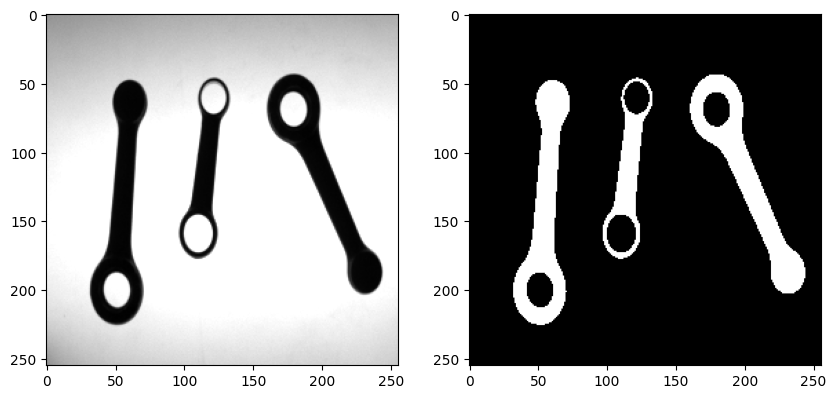

In [5]:
tresh, binarized_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

f, plts = plt.subplots(1, 2, figsize=(10,10)) 
plts[0].imshow(img, cmap="gray")
plts[1].imshow(binarized_img, cmap="gray")
plt.show()

Compute connected components

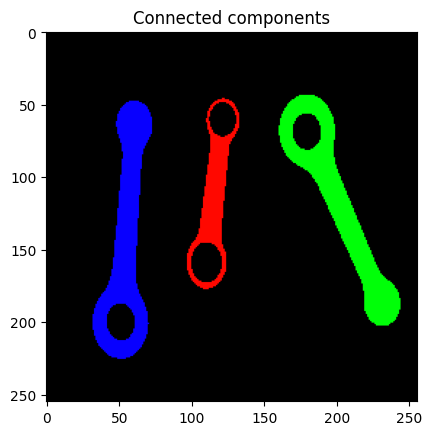

In [6]:
CONNECTIVITY = 8

num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binarized_img, connectivity=CONNECTIVITY)

label_hue = np.uint8(179 * labels / np.max(labels))
blank_ch = 255 * np.ones_like(label_hue)
labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
labeled_img[label_hue == 0] = 0

plt.imshow(labeled_img)
plt.title("Connected components")
plt.show()

## Detect holes

In [7]:
def get_component(labels, label):
    component = np.zeros_like(labels, dtype=np.uint8)
    component[labels == label] = 255

    return component

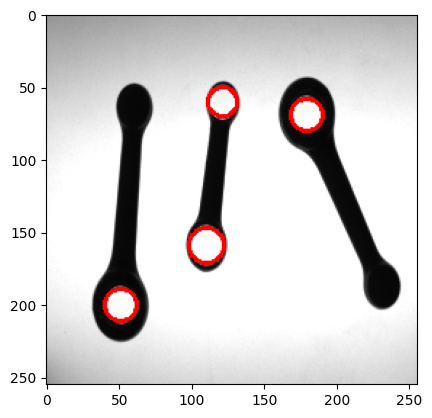

In [8]:
holes = []

for i in range(1, num_labels):
    component = get_component(labels, i)

    num_labels_c, labels_c, stats_c, centroids_c = cv2.connectedComponentsWithStats(255 - component, connectivity=CONNECTIVITY)

    for j in range(2, num_labels_c):
        diameter = math.sqrt(stats_c[j][4] / math.pi)

        hole = (centroids_c[j], diameter)
        holes.append(hole)

draw_hole_img = cv2.cvtColor(img.copy(), cv2.COLOR_GRAY2BGR)

for hole in holes:
    draw_hole_img = cv2.circle(draw_hole_img, np.rint(hole[0]).astype(int),  round(hole[1]), (255,0,0), 2)

plt.imshow(draw_hole_img)
plt.show()

## Compute moments